In [1]:
import pandas as pd
import re
import random
import functools
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
random.seed(89)
random_seeds = random.sample(range(0, 500), 10)
random_seeds

[41, 393, 310, 360, 132, 71, 176, 436, 33, 76]

In [3]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_df['TransactionDate'] = pd.to_datetime(train_df['TransactionDate'])
test_df['TransactionDate'] = pd.to_datetime(test_df['TransactionDate'])

def ageCleaning(df):
    df.loc[df['Age'] < 0, 'Age'] = df['Age'].abs()
    df.loc[df['Age'] > 1000, 'Age'] = df['Age'] / 1000
    return df

train_df = ageCleaning(train_df)
test_df = ageCleaning(test_df)

# Function to convert the values to AUD and floats
# Function to convert the values to AUD and floats


def convert_to_aud(row):
    # Normalize the pound symbol encoding
    row = row.replace('¬£', '£').strip()

    # Check for AU$ with or without space
    if re.match(r'^AU\$\s*\d+\.?\d*', row):
        match = re.search(r'^AU\$\s*(\d+\.?\d*)', row)
        if match:
            return float(match.group(1))
    if re.match(r'^AED\s*\d+\.?\d*', row):
      match = re.search(r'^AED\s*(\d+\.?\d*)', row)
      if match:
          aed_value = float(match.group(1))
          aud_value = aed_value * 0.41
          return round(aud_value, 2)

    # Check for specific currencies with space
    match = re.search(r'(\d+\.?\d*)\s*(AUD|AED|GBP|£)', row)
    if match:
        value, currency = match.groups()
        value = float(value)

        if currency == 'AED':
            return round(value * 0.41, 2)  # Convert AED to AUD
        elif currency in ['GBP', '£']:
            return round(value * 1.96, 2)  # Convert GBP to AUD
        else:
            return round(value, 2)  # No conversion needed for AUD

    # If only numbers are found, assume it's in AED and convert to AUD
    elif re.match(r'^\d+\.?\d*$', row):
        value = float(row)
        return round(value * 0.41, 2)  # Convert assumed AED to AUD

    return None

# Apply the function to the DataFrame
train_df['TransactionAmount'] = train_df['TransactionAmount'].apply(convert_to_aud)
train_df['Income'] = train_df['Income'].apply(convert_to_aud)
train_df['Expenditure'] = train_df['Expenditure'].apply(convert_to_aud)
train_df['GiftsTransaction'] = train_df['GiftsTransaction'].apply(convert_to_aud)
test_df['TransactionAmount'] = test_df['TransactionAmount'].apply(convert_to_aud)
test_df['Income'] = test_df['Income'].apply(convert_to_aud)
test_df['Expenditure'] = test_df['Expenditure'].apply(convert_to_aud)
test_df['GiftsTransaction'] = test_df['GiftsTransaction'].apply(convert_to_aud)


train_df['GiftsTransaction'] = train_df['GiftsTransaction'].fillna(0)
test_df['GiftsTransaction'] = test_df['GiftsTransaction'].fillna(0)

In [4]:
def email(file_name):

  domains = set()
  emails = test_df["EmailDomain"]
  pattern = r'^\S+@(\S+)' #groups the email domains
  matches = emails.str.extract(pattern)[0]

  for match in matches:
    domains.add(match)

  return matches
email(train_df)
email(test_df)

0       outlook.com
1         gmail.com
2         yahoo.com
3         gmail.com
4       outlook.com
           ...     
7307      gmail.com
7308      yahoo.com
7309      gmail.com
7310      gmail.com
7311      gmail.com
Name: 0, Length: 7312, dtype: object

In [5]:
# change isnotfemale, he, into male
train_df["Gender"] = train_df["Gender"].replace(["isnotfemale", "he", "Male", "man"], "male")

# change fem, woman
train_df["Gender"] = train_df["Gender"].replace(["isnotmale","fem","she","woman","Female"], "female")

# Cleaning Device Types
train_df["DeviceType"] = train_df["DeviceType"].replace(["android", "galaxys7", "iphone 15", "smartphone", "mob", "Mobile"], "mobile")
train_df["DeviceType"] = train_df["DeviceType"].str.lower()

# Clean Transaction Location
train_df["TransactionLocation"] = train_df["TransactionLocation"].str.lower()
train_df["TransactionLocation"] = train_df["TransactionLocation"].replace(["adelaide city", "adl"], "adelaide")
train_df["TransactionLocation"] = train_df["TransactionLocation"].replace("bne", "brisbane")
train_df["TransactionLocation"] = train_df["TransactionLocation"].replace("cbr", "canberra")
train_df["TransactionLocation"] = train_df["TransactionLocation"].replace("drw", "darwin")
train_df["TransactionLocation"] = train_df["TransactionLocation"].replace("hbt", "hobart")
train_df["TransactionLocation"] = train_df["TransactionLocation"].replace("pth", "perth")
train_df["TransactionLocation"] = train_df["TransactionLocation"].replace("syd", "sydney")
train_df["TransactionLocation"] = train_df["TransactionLocation"].replace(["melb", "melburn", "mel", "mlb"], "melbourne")
# Dropping the year and creating a new column for month and date
train_df['TransDateMonth'] = train_df['TransactionDate'].dt.strftime('%m-%d')


# change isnotfemale, he, into male
test_df["Gender"] = test_df["Gender"].replace(["isnotfemale", "he", "Male", "man"], "male")

# change fem, woman
test_df["Gender"] = test_df["Gender"].replace(["isnotmale","fem","she","woman","Female"], "female")

# Cleaning Device Types
test_df["DeviceType"] = test_df["DeviceType"].replace(["android", "galaxys7", "iphone 15", "smartphone", "mob", "Mobile"], "mobile")
test_df["DeviceType"] = test_df["DeviceType"].str.lower()

# Clean Transaction Location
test_df["TransactionLocation"] = test_df["TransactionLocation"].str.lower()
test_df["TransactionLocation"] = test_df["TransactionLocation"].replace(["adelaide city", "adl"], "adelaide")
test_df["TransactionLocation"] = test_df["TransactionLocation"].replace("bne", "brisbane")
test_df["TransactionLocation"] = test_df["TransactionLocation"].replace("cbr", "canberra")
test_df["TransactionLocation"] = test_df["TransactionLocation"].replace("drw", "darwin")
test_df["TransactionLocation"] = test_df["TransactionLocation"].replace("hbt", "hobart")
test_df["TransactionLocation"] = test_df["TransactionLocation"].replace("pth", "perth")
test_df["TransactionLocation"] = test_df["TransactionLocation"].replace("syd", "sydney")
test_df["TransactionLocation"] = test_df["TransactionLocation"].replace(["melb", "melburn", "mel", "mlb"], "melbourne")
# Dropping the year and creating a new column for month and date
test_df['TransDateMonth'] = test_df['TransactionDate'].dt.strftime('%m-%d')



#Make a new Lat_Long attribute
train_df['Lat_Long'] = train_df['Latitude'].astype(str) + ',' + train_df['Longitude'].astype(str)
test_df['Lat_Long'] = test_df['Latitude'].astype(str) + ',' + test_df['Longitude'].astype(str)

In [6]:
def clean_time(time_str):
    # replacing the slashes with colons
    time_str = time_str.replace('/', ':')
    # Handle AM/PM formats
    try:
        time_obj = pd.to_datetime(time_str, format='%I:%M:%S %p') if 'AM' in time_str or 'PM' in time_str else pd.to_datetime(time_str, format='%H:%M:%S')
        return time_obj.hour
    except ValueError:
        return None  # If the time format is invalid, return None

train_df['Hour'] = train_df['TransactionTime'].apply(clean_time)
test_df['Hour'] = test_df['TransactionTime'].apply(clean_time)

In [7]:
le = LabelEncoder()
le.fit(train_df['Gender'])
train_df['Gender'] = le.transform(train_df['Gender'])
le.fit(train_df['Occupation'])
train_df['Occupation'] = le.transform(train_df['Occupation'])
le.fit(train_df['EducationLevel'])
train_df['EducationLevel'] = le.transform(train_df['EducationLevel'])
le.fit(train_df['MaritalStatus'])
train_df['MaritalStatus'] = le.transform(train_df['MaritalStatus'])
le.fit(train_df['TransactionType'])
train_df['TransactionType'] = le.transform(train_df['TransactionType'])
le.fit(train_df['TransactionLocation'])
train_df['TransactionLocation'] = le.transform(train_df['TransactionLocation'])
le.fit(train_df['DeviceType'])
train_df['DeviceType'] = le.transform(train_df['DeviceType'])
le.fit(train_df['EmailDomain'])
train_df['EmailDomain'] = le.transform(train_df['EmailDomain'])
le.fit(train_df['MerchantID'])
train_df['MerchantID'] = le.transform(train_df['MerchantID'])
le.fit(train_df['Terrorism'])
train_df['Terrorism'] = le.transform(train_df['Terrorism'])
date_freq = train_df['TransDateMonth'].value_counts(normalize=True)
train_df['TransDateMonth'] = train_df['TransDateMonth'].map(date_freq)
lat_long_freq = train_df['Lat_Long'].value_counts(normalize=True)
train_df['Lat_Long'] = train_df['Lat_Long'].map(lat_long_freq)




le.fit(test_df['Gender'])
test_df['Gender'] = le.transform(test_df['Gender'])
le.fit(test_df['Occupation'])
test_df['Occupation'] = le.transform(test_df['Occupation'])
le.fit(test_df['EducationLevel'])
test_df['EducationLevel'] = le.transform(test_df['EducationLevel'])
le.fit(test_df['MaritalStatus'])
test_df['MaritalStatus'] = le.transform(test_df['MaritalStatus'])
le.fit(test_df['TransactionType'])
test_df['TransactionType'] = le.transform(test_df['TransactionType'])
le.fit(test_df['TransactionLocation'])
test_df['TransactionLocation'] = le.transform(test_df['TransactionLocation'])
le.fit(test_df['DeviceType'])
test_df['DeviceType'] = le.transform(test_df['DeviceType'])
le.fit(test_df['EmailDomain'])
test_df['EmailDomain'] = le.transform(test_df['EmailDomain'])
le.fit(test_df['MerchantID'])
test_df['MerchantID'] = le.transform(test_df['MerchantID'])
le.fit(test_df['Terrorism'])
test_df['Terrorism'] = le.transform(test_df['Terrorism'])
date_freq = test_df['TransDateMonth'].value_counts(normalize=True)
test_df['TransDateMonth'] = test_df['TransDateMonth'].map(date_freq)
lat_long_freq = test_df['Lat_Long'].value_counts(normalize=True)
test_df['Lat_Long'] = test_df['Lat_Long'].map(lat_long_freq)

In [8]:
trans_num = pd.DataFrame(test_df['TransactionNumber'])
train_df = train_df.drop(columns=['Latitude', 'Longitude', 'TransactionNumber', 'UserID', 'TransactionDate', 'TransactionTime'])
test_df = test_df.drop(columns=['Latitude', 'Longitude', 'TransactionNumber', 'UserID', 'TransactionDate', 'TransactionTime'])

<Axes: >

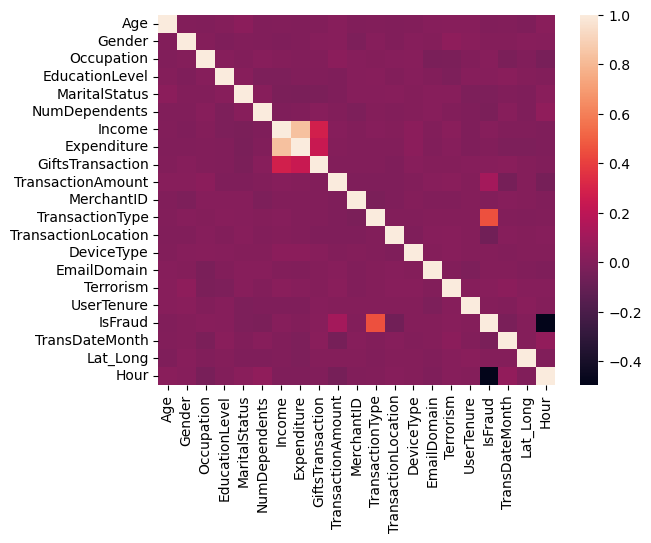

In [9]:
import seaborn as sns
sns.heatmap(train_df.corr())

In [10]:
#Split train data for training and model evaluation data split
y = train_df['IsFraud']
X = train_df
X = X.drop(columns=['IsFraud'])

In [11]:
train_df

,Age,Gender,Occupation,EducationLevel,MaritalStatus,NumDependents,Income,Expenditure,GiftsTransaction,TransactionAmount,...,TransactionType,TransactionLocation,DeviceType,EmailDomain,Terrorism,UserTenure,IsFraud,TransDateMonth,Lat_Long,Hour
0,37,0,0,0,3,3,28884.43,14610.61,0.00,258.14,...,3,0,1,1942,0,113,1,0.001550,0.289987,12
1,34,1,2,1,1,4,54919.07,39169.49,0.00,34.94,...,3,2,1,1107,0,104,1,0.001641,0.300930,18
2,25,1,3,2,1,2,74728.57,55873.76,0.00,323.82,...,1,1,1,1232,0,105,0,0.003739,0.289987,17
3,25,1,0,1,1,3,55712.62,36756.11,4335.70,13.32,...,1,3,1,2096,0,70,1,0.002736,0.300930,0
4,38,1,0,1,2,4,53004.70,17876.42,4763.48,467.71,...,3,5,2,2270,0,27,0,0.004012,0.300930,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10961,25,1,3,1,2,3,64488.68,21813.53,5379.28,182.51,...,1,2,1,3432,0,110,0,0.002918,0.300930,23
10962,18,0,0,1,1,2,80403.31,63429.08,0.00,137.50,...,1,4,1,3260,0,91,1,0.002462,0.300930,2
10963,22,1,3,1,3,3,29048.42,18806.31,100.02,112.37,...,1,2,1,911,1,84,0,0.008572,0.289987,9
10964,29,0,2,1,0,4,28654.66,9748.53,0.00,68.05,...,1,2,1,2800,0,62,1,0.001824,0.300930,5


In [12]:
#Normalization/Scaling of all attributes 
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
test = pd.DataFrame(scaler.fit_transform(test_df), columns=test_df.columns)

In [13]:
#KNN Classifier
knn = KNeighborsClassifier(n_neighbors=10)

#Neural Network performance evaluation
mlp = MLPClassifier(hidden_layer_sizes=(25,20,20), activation='relu', solver='adam', max_iter=100, random_state=69)

#Bin discretarise train and test data for the Random Forest classifier model
X_bin = X.copy()
num_bins = 5  
for column in X_bin.columns:
    X_bin['{}'.format(column)] = pd.qcut(X_bin[column], q=num_bins, duplicates='drop').apply(lambda x: x.mid)
        

test_bin = test_df.copy()
for column in test_bin.columns:
    test_bin['{}'.format(column)] = pd.qcut(test_bin[column], q=num_bins, duplicates='drop').apply(lambda x: x.mid)

#Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=46)

#Stacking claffier model
estimators = [('knn', KNeighborsClassifier(n_neighbors=10)), ('nn', MLPClassifier(hidden_layer_sizes=(25,20,20), activation='relu', solver='adam', max_iter=100, random_state=69)), ('rf', RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=46), ('grad', GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=40)))]
stack = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), cv = 10)

#GradBoost classifier model
grad = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=40)

In [14]:
# Feature selection using mutual information (out of 19 columns) (haven't done anything with with yet, no feature was dropped, if u want to drop features,
#set it to K
X_new = X.copy()
test_new = test.copy()

#k is the number of features we want to select
mutual_info_classif_rand_state = functools.partial(mutual_info_classif, random_state=2)
selector = SelectKBest(score_func=mutual_info_classif, k=20)

# Fit and transform the data
X_selected = selector.fit_transform(X_new, y)
scores = scores = selector.scores_


# Get the indices of the selected features
selected_indices = selector.get_support(indices=True)
scores = scores = selector.scores_

print("Selected indices:", selected_indices)


#Get the selected and non-selected features
selected_features = [X_new.columns[index] for index in selected_indices]
features_to_drop = [col for col in X_new.columns if col not in selected_features]

print('Selected: ', selected_features)
print('To drop: ', features_to_drop)

#Drop the non-selected features
X_new = X_new.drop(columns=features_to_drop)
test_new = test_new.drop(columns=features_to_drop)

Selected indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Selected:  ['Age', 'Gender', 'Occupation', 'EducationLevel', 'MaritalStatus', 'NumDependents', 'Income', 'Expenditure', 'GiftsTransaction', 'TransactionAmount', 'MerchantID', 'TransactionType', 'TransactionLocation', 'DeviceType', 'EmailDomain', 'Terrorism', 'UserTenure', 'TransDateMonth', 'Lat_Long', 'Hour']
To drop:  []


In [ ]:
#Predict test data instances with trained models after fearture selection
X_train, X_test, y_train, y_test= train_test_split(X_new, y, test_size=0.1, random_state=89)
knn.fit(X_train, y_train)
mlp.fit(X_train, y_train)
stack.fit(X_train, y_train)
grad.fit(X_train, y_train)
knn_predict = knn.predict(X_test)
nn_predict = mlp.predict(X_test)
stack_predict = stack.predict(X_test)
grad_predict = grad.predict(X_test)
print(classification_report(y_test, knn_predict))
print(classification_report(y_test, nn_predict))
print(classification_report(y_test, stack_predict))
print(classification_report(y_test, grad_predict))
X_train, X_test, y_train, y_test= train_test_split(X_bin, y, test_size=0.1, random_state=89)
rf_classifier.fit(X_train, y_train)
rf_predict = rf_classifier.predict(X_test)
print(classification_report(y_test, rf_predict))

#Dataframe to see which points each model predicts correctly. i.e 1 is correct, 0 is incorrect
models_eval = pd.DataFrame({"Neural Network": nn_predict.tolist(), "KNN": knn_predict.tolist(), "Random Forest": rf_predict.tolist(), "GradBoost": grad_predict, "Real Score": y_test}) 
models_eval.loc[models_eval['Neural Network'] == models_eval['Real Score'], 'Neural Network'] = 1
models_eval.loc[models_eval['KNN'] == models_eval['Real Score'], 'KNN'] = 1
models_eval.loc[models_eval['Random Forest'] == models_eval['Real Score'], 'Random Forest'] = 1
models_eval.loc[models_eval['GradBoost'] == models_eval['GradBoost'], 'GradBoost'] = 1
models_eval.loc[models_eval['Neural Network'] != 1, 'Neural Network'] = 0
models_eval.loc[models_eval['KNN'] != 1, 'KNN'] = 0
models_eval.loc[models_eval['Random Forest'] != 1, 'Random Forest'] = 0
models_eval.loc[models_eval['GradBoost'] != 1, 'GradBoost'] = 0
models_eval['Probability of getting right predict'] = models_eval[['Neural Network', 'KNN', 'Random Forest', 'GradBoost']].mean(axis=1)
models_eval['Probability of getting right predict'].value_counts()

C:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer

In [ ]:
#Feature importance for Tree-base like models
rf = rf_classifier.fit(X_train, y_train)
boost = grad.fit(X_train, y_train)
print(rf.feature_importances_)
print(boost.feature_importances_)
list(train_df.columns)

In [ ]:
#KNN model performance evaluation
train_acc = []
test_acc = []
for size in range(9):
    X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=1-((size+1)/10), random_state=89)
    knn.fit(X_train, y_train)
    knn_predict = knn.predict(X_test)
    knn_train_predict = knn.predict(X_train)
    train_acc.append(accuracy_score(y_train, knn_train_predict))
    test_acc.append(accuracy_score(y_test, knn_predict))

#Learning curves
train_sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8 , 0.9]
plot_data = pd.DataFrame({"Train sizes": train_sizes, "Train accuracy": train_acc, "Test accuracy": test_acc})
plot_data.plot(x ="Train sizes", y = ["Train accuracy", "Test accuracy"], xlabel="Percentage of training instances", ylabel="Classification accuracy", title="Learning Curves")
train_acc = [1 - x for x in train_acc]
test_acc = [1 - x for x in test_acc]
plot_data = pd.DataFrame({"Train sizes": train_sizes, "Train error rate": train_acc, "Test error rate": test_acc})
plot_data.plot(x ="Train sizes", y = ["Train error rate", "Test error rate"], xlabel="Percentage of training instances", ylabel="Classification accuracy", title="Error Curves")

In [ ]:
#Neural Network performance evaluation
train_acc = []
test_acc = []
for size in range(9):
    X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=1-((size+1)/10), random_state=89)
    mlp.fit(X_train,y_train)
    nn_predict = mlp.predict(X_test)
    nn_train_predict = mlp.predict(X_train)
    train_acc.append(accuracy_score(y_train, nn_train_predict))
    test_acc.append(accuracy_score(y_test, nn_predict))

#Learning curves
train_sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8 , 0.9]
plot_data = pd.DataFrame({"Train sizes": train_sizes, "Train accuracy": train_acc, "Test accuracy": test_acc})
plot_data.plot(x ="Train sizes", y = ["Train accuracy", "Test accuracy"], xlabel="Percentage of training instances", ylabel="Classification accuracy", title="Learning Curves")
train_acc = [1 - x for x in train_acc]
test_acc = [1 - x for x in test_acc]
plot_data = pd.DataFrame({"Train sizes": train_sizes, "Train error rate": train_acc, "Test error rate": test_acc})
plot_data.plot(x ="Train sizes", y = ["Train error rate", "Test error rate"], xlabel="Percentage of training instances", ylabel="Classification accuracy", title="Error Curves")


In [ ]:
#Random Forest Classifier model performance evaluation
train_acc = []
test_acc = []
for size in range(9):
    X_train, X_test, y_train, y_test= train_test_split(X_bin, y, test_size=1-((size+1)/10), random_state=89)
    rf_classifier.fit(X_train, y_train)
    rf_predict = rf_classifier.predict(X_test)
    rf_train_predict = rf_classifier.predict(X_train)
    train_acc.append(accuracy_score(y_train, rf_train_predict))
    test_acc.append(accuracy_score(y_test, rf_predict))

#Learning curves
train_sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8 , 0.9]
plot_data = pd.DataFrame({"Train sizes": train_sizes, "Train accuracy": train_acc, "Test accuracy": test_acc})
plot_data.plot(x ="Train sizes", y = ["Train accuracy", "Test accuracy"], xlabel="Percentage of training instances", ylabel="Classification accuracy", title="Learning Curves")
train_acc = [1 - x for x in train_acc]
test_acc = [1 - x for x in test_acc]
plot_data = pd.DataFrame({"Train sizes": train_sizes, "Train error rate": train_acc, "Test error rate": test_acc})
plot_data.plot(x ="Train sizes", y = ["Train error rate", "Test error rate"], xlabel="Percentage of training instances", ylabel="Classification accuracy", title="Error Curves")


In [ ]:
#Stacking model performance evaluation
train_acc = []
test_acc = []
for size in range(9):
    X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=1-((size+1)/10), random_state=89)
    stack.fit(X_train, y_train)
    stack_predict = stack.predict(X_test)
    stack_train_predict = stack.predict(X_train)
    train_acc.append(accuracy_score(y_train, stack_train_predict))
    test_acc.append(accuracy_score(y_test, stack_predict))
    

#Learning curves
train_sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8 , 0.9]
plot_data = pd.DataFrame({"Train sizes": train_sizes, "Train accuracy": train_acc, "Test accuracy": test_acc})
plot_data.plot(x ="Train sizes", y = ["Train accuracy", "Test accuracy"], xlabel="Percentage of training instances", ylabel="Classification accuracy", title="Learning Curves")
train_acc = [1 - x for x in train_acc]
test_acc = [1 - x for x in test_acc]
plot_data = pd.DataFrame({"Train sizes": train_sizes, "Train error rate": train_acc, "Test error rate": test_acc})
plot_data.plot(x ="Train sizes", y = ["Train error rate", "Test error rate"], xlabel="Percentage of training instances", ylabel="Classification accuracy", title="Error Curves")

In [ ]:
#GradBoost performance evaluation
train_acc = []
test_acc = []
for size in range(9):
    X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=1-((size+1)/10), random_state=89)
    grad.fit(X_train, y_train)
    grad_predict = grad.predict(X_test)
    grad_train_predict = grad.predict(X_train)
    train_acc.append(accuracy_score(y_train, grad_train_predict))
    test_acc.append(accuracy_score(y_test, grad_predict))

#Learning curves
train_sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8 , 0.9]
plot_data = pd.DataFrame({"Train sizes": train_sizes, "Train accuracy": train_acc, "Test accuracy": test_acc})
plot_data.plot(x ="Train sizes", y = ["Train accuracy", "Test accuracy"], xlabel="Percentage of training instances", ylabel="Classification accuracy", title="Learning Curves")
train_acc = [1 - x for x in train_acc]
test_acc = [1 - x for x in test_acc]
plot_data = pd.DataFrame({"Train sizes": train_sizes, "Train error rate": train_acc, "Test error rate": test_acc})
plot_data.plot(x ="Train sizes", y = ["Train error rate", "Test error rate"], xlabel="Percentage of training instances", ylabel="Classification accuracy", title="Error Curves")

In [ ]:
#Gather predictions
valid_knn_predict = knn.predict(test)
valid_nn_predict = mlp.predict(test)
valid_rf_predict = rf_classifier.predict(test_bin)
valid_stack_predict = stack.predict(test)
valid_grad_predict = grad.predict(test)

In [ ]:
valid_stack_predict[:700]

In [ ]:
valid_grad_predict[:700]

In [ ]:
#Create submission file
import csv

with open('submission.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    field = ["TransactionNumber", "IsFraud"]
    
    writer.writerow(field)
    for i in range(len(valid_stack_predict)):
        writer.writerow([trans_num['TransactionNumber'][i], valid_stack_predict[i].round()])